## Inverse problems in image processing - TD 9

                                  e-mail: jayousi@unice.fr
                                  date: 17 / 03 / 2022


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import torch
import torch.nn as nn
import torch.nn.functional as F
from practice09_LISTA import *
from scipy.linalg import orth

pio.templates.default = 'plotly_white'

In [2]:
%reload_ext autoreload
%autoreload 2

In Sparse Coding (SC), input vectors are reconstructed using a sparse linear combination of basis vectors. SC has become a popular method for extracting features from data. For a given input, SC minimizes a quadratic reconstruction error with an L1 penalty term on the code.

In this TD we will describe and implement two algrorithms for finding sparse codes: the Iterative Shrinkage and Thresholding Algorithm (ISTA) [1],[2] and the Learned ISTA (LISTA) [3]


## ISTA Implementation

First of all, we will define the shrinkage function that we will need in the ISTA algorithm:


In [3]:
# shrinkage

The pseudocode of ISTA:

<div>
<img src="image1.JPG" width="400"/>
</div>
Find bellow the implementation of the ISTA algorithm. The sparse solution and the reconstruction error are returned. Please, fill in the gaps.


In [4]:
# ista

## From ISTA to LISTA

<div>
<img src="image2.JPG" width="500"/>
</div>

**Top:**
The block diagram of the ISTA algorithm for sparse coding. The optimal sparse code is the fixed point of
$$
Z(k + 1) = h_θ(W_e X − S Z(k))
$$
where $X$ is the input, $h_θ$ is a coordinate-wise shrinking function with threshold $θ$, $W_e$ is the transpose of the dictionary matrix $W_d$ (whose columns are the basis vectors), and $S$ is $W_d^T W_d$.

**Bottom:**
The approximator “Learned ISTA”, uses a time unfolded version of the ISTA block diagram, truncated to a fixed number of iterations (3 here). The matrices $W_e$ and $S$, are learned, so as to minimize the approximation error to the optimal sparse code on a given dataset. The method allows us to impose restrictions on $S$ so as to further reduce the computational burden (e.g. keeping many terms at 0, or using a low-rank factorized form).


#### Questions

1. Using the notation from Algorithm 1, express $W_e$ and $S$.


## LISTA Implementation

Find bellow the implementation of the LISTA algorithm.


In [5]:
# LISTA

For LISTA, an additional training step is required.

Let's first train LISTA.

The sparse signal dimension is 1000, the measurement signal dimension is 256, the signal sparsity is 5, and 5000 training samples are used.


In [6]:
device

device(type='cuda')

In [31]:
# dimensions of the sparse signal, measurement and sparsity
m = 1000
n = 256
k = 5

# generate dictionary
Psi = np.eye(m)
Phi = np.random.randn(n, m)
Phi = np.transpose(orth(np.transpose(Phi)))
w_d = np.dot(Phi, Psi)

# number of training samples
N = 5000

# generate Sparse Signal the z and Measurement x
z = np.zeros((N, m))
x = np.zeros((N, n))

for I in range(N):
  index_k = np.random.choice(a=m, size=k, replace=False)
  z[I, index_k] = 0.5 * np.random.randn(k, 1).reshape(-1)
  x[I] = np.dot(w_d, z[I, :])

# train LISTA
net, err_list = train_lista(Y=x, dictionary=w_d, a=0.05, L=2, max_iter=30)


Epoch   3: Loss: 0.000067
Epoch   6: Loss: 0.000065
Epoch   9: Loss: 0.000062
Epoch  12: Loss: 0.000065
Epoch  15: Loss: 0.000063
Epoch  18: Loss: 0.000063
Epoch  21: Loss: 0.000061
Epoch  24: Loss: 0.000061
Epoch  27: Loss: 0.000060
Epoch  30: Loss: 0.000059
Epoch  33: Loss: 0.000059
Epoch  36: Loss: 0.000058
Epoch  39: Loss: 0.000058
Epoch  42: Loss: 0.000057
Epoch  45: Loss: 0.000059
Epoch  48: Loss: 0.000057
Epoch  51: Loss: 0.000057
Epoch  54: Loss: 0.000059
Epoch  57: Loss: 0.000056
Epoch  60: Loss: 0.000053
Epoch  63: Loss: 0.000055
Epoch  66: Loss: 0.000055
Epoch  69: Loss: 0.000054
Epoch  72: Loss: 0.000054
Epoch  75: Loss: 0.000055
Epoch  78: Loss: 0.000053
Epoch  81: Loss: 0.000053
Epoch  84: Loss: 0.000054
Epoch  87: Loss: 0.000052
Epoch  90: Loss: 0.000053
Epoch  93: Loss: 0.000052
Epoch  96: Loss: 0.000052
Epoch  99: Loss: 0.000051


In [32]:
fig = go.Figure()
fig.add_trace(
  go.Scatter(y=[err.item() for err in err_list], mode="lines", name="LISTA")
)
fig.update_layout(
  title="Reconstruction Error",
  xaxis_title="Iteration",
  yaxis_title="Reconstruction Error",
)


#### Questions

2. Try to understand the algorithm. Do you have any questions?

3. Which parameters are trained?

4. Using the notation of Algorithm 1, express the threshold "theta" given as an input in the class LISTA() above. Is this parameter trained?


## An example of sparse reconstruction

Create a test dataset


In [33]:
# dimensions of the sparse signal, measurement and sparsity
m, n, k = 1000, 256, 5

# number of test examples
N = 1

# generate Sparse Signal the z and Measurement x
z = np.zeros((N, m))
x = np.zeros((N, n))

for I in range(N):
  index_k = np.random.choice(a=m, size=k, replace=False)
  z[I, index_k] = 0.5 * np.random.randn(k, 1).reshape(-1)
  x[I] = np.dot(w_d, z[I, :])


Test the performance of LISTA and ISTA algorithm. Compare the sparse solutions obtained.


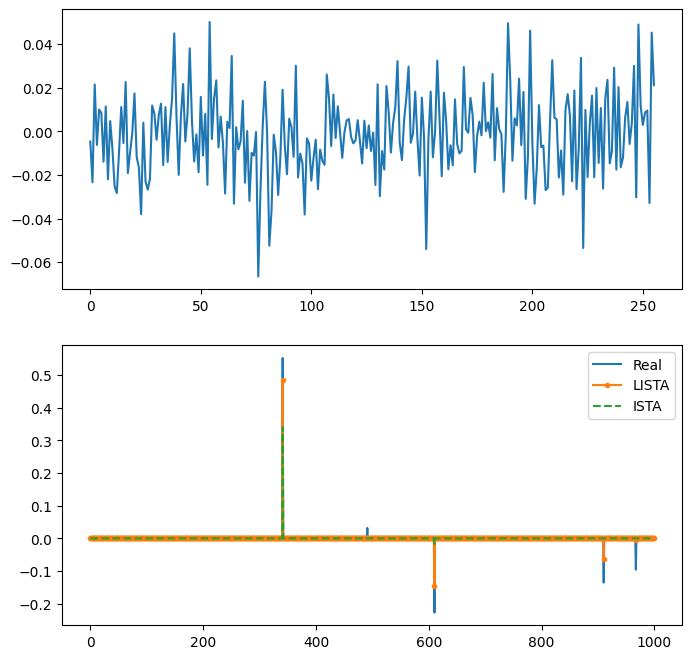

In [34]:
# Plot Measurement x
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(x.flatten())

# Plot Ground Truth of Sparse Signal
plt.subplot(2, 1, 2)
plt.plot(z.flatten(), label="Real")

# Reconstruction using LISTA
z_recon = net(torch.from_numpy(x).float().to(device))
z_recon = z_recon.detach().cpu().numpy()
# Plot LISTA solution
plt.subplot(2, 1, 2)
plt.plot(z_recon.flatten(), ".-", label="LISTA")
plt.legend()

# Reconstruction using ISTA
z_recon, recon_errors = ista(np.mat(x).T, np.mat(w_d), 0.05, 2, 1000, 0.00001)
# Plot ISTA solution
plt.subplot(2, 1, 2)
plt.plot(z_recon, "--", label="ISTA")
plt.legend()


#### Questions

5. You can plot the least square term evolution (recon_error) when ISTA algorithm was used. Also, you can plot the loss function evolution while LISTA has been used.

6. Evaluate the reconstructions obtained using ISTA and LISTA. As we already know the ground truth vector ($z_{GT}$) we can compute for example the error: error = $\| z_{GT} - z_{rec}\|_2$

7. Play with the training parameters: number of training samples (N), number of epochs, learning_rate. What do you observe?

8. Play with the parameter that controls the sparsity level (a) in both ISTA/LISTA.


This TD is based on the article found at: https://blog.karthisoftek.com/ where ISTA and LISTA implementations were provided.

#### Main References:

[1] Daubechies, I., Defrise, M. and De Mol, C. (2004), An iterative thresholding algorithm for linear inverse problems with a sparsity constraint. Comm. Pure Appl. Math., 57: 1413-1457. https://doi.org/10.1002/cpa.20042

[2] Beck, A. & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear inverse problems. SIAM Journal on Imaging Sciences, 2, 183--202.
https://www.ceremade.dauphine.fr/~carlier/FISTA

[3] Gregor, K. & LeCun, Y. (2010). Learning Fast Approximations of Sparse Coding.. In J. Fürnkranz & T. Joachims (eds.), ICML (p./pp. 399-406), : Omnipress.
https://icml.cc/Conferences/2010/papers/449.pdf
